In [17]:
!pip install fredapi PyPortfolioOpt

#### Importing necessary libraries

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px

from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel
from pypfopt import DiscreteAllocation

#### Defining a list of stock tickers

In [19]:
tickers = [    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'NVDA',
    'GOOGL',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'HSY']


In [91]:
closing_prices = []
decision_period = 15
for ticker in tickers:
    stock = yf.Ticker(ticker)
    history = stock.history(period=str(decision_period)+'d')
    if not history.empty:
        closing_prices.extend(history['Close'].values)
    else:
        closing_prices.extend([float('NaN')]*(16))
print(len(closing_prices))


225


#### Setting up start and end dates for data retrieval

In [20]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 3*365)

#### Retrieving adjusted close prices for each ticker and storing in a DataFrame

In [21]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [22]:
adj_close_df.head(3)

,AAPL,MSFT,META,AMZN,NVDA,GOOGL,HD,ABBV,KO,DIS,T,UPS,LMT,CAT,HSY
Date,,,,,,,,,,,,,,,
2021-04-09,130.720337,249.271500,312.128815,168.610001,143.719025,113.533501,296.849701,95.135986,48.557419,187.279633,18.526148,159.566208,355.764709,216.554977,150.263138
2021-04-12,128.990509,249.329941,311.209808,168.969498,151.793228,112.231003,298.300323,95.764084,48.712639,185.884186,18.476814,161.960526,357.256897,216.723907,150.357346
2021-04-13,132.125839,251.843597,309.431702,170.000000,156.489075,112.721497,297.937653,95.737549,48.475239,184.887436,18.273291,162.722351,356.575226,215.241104,149.622513


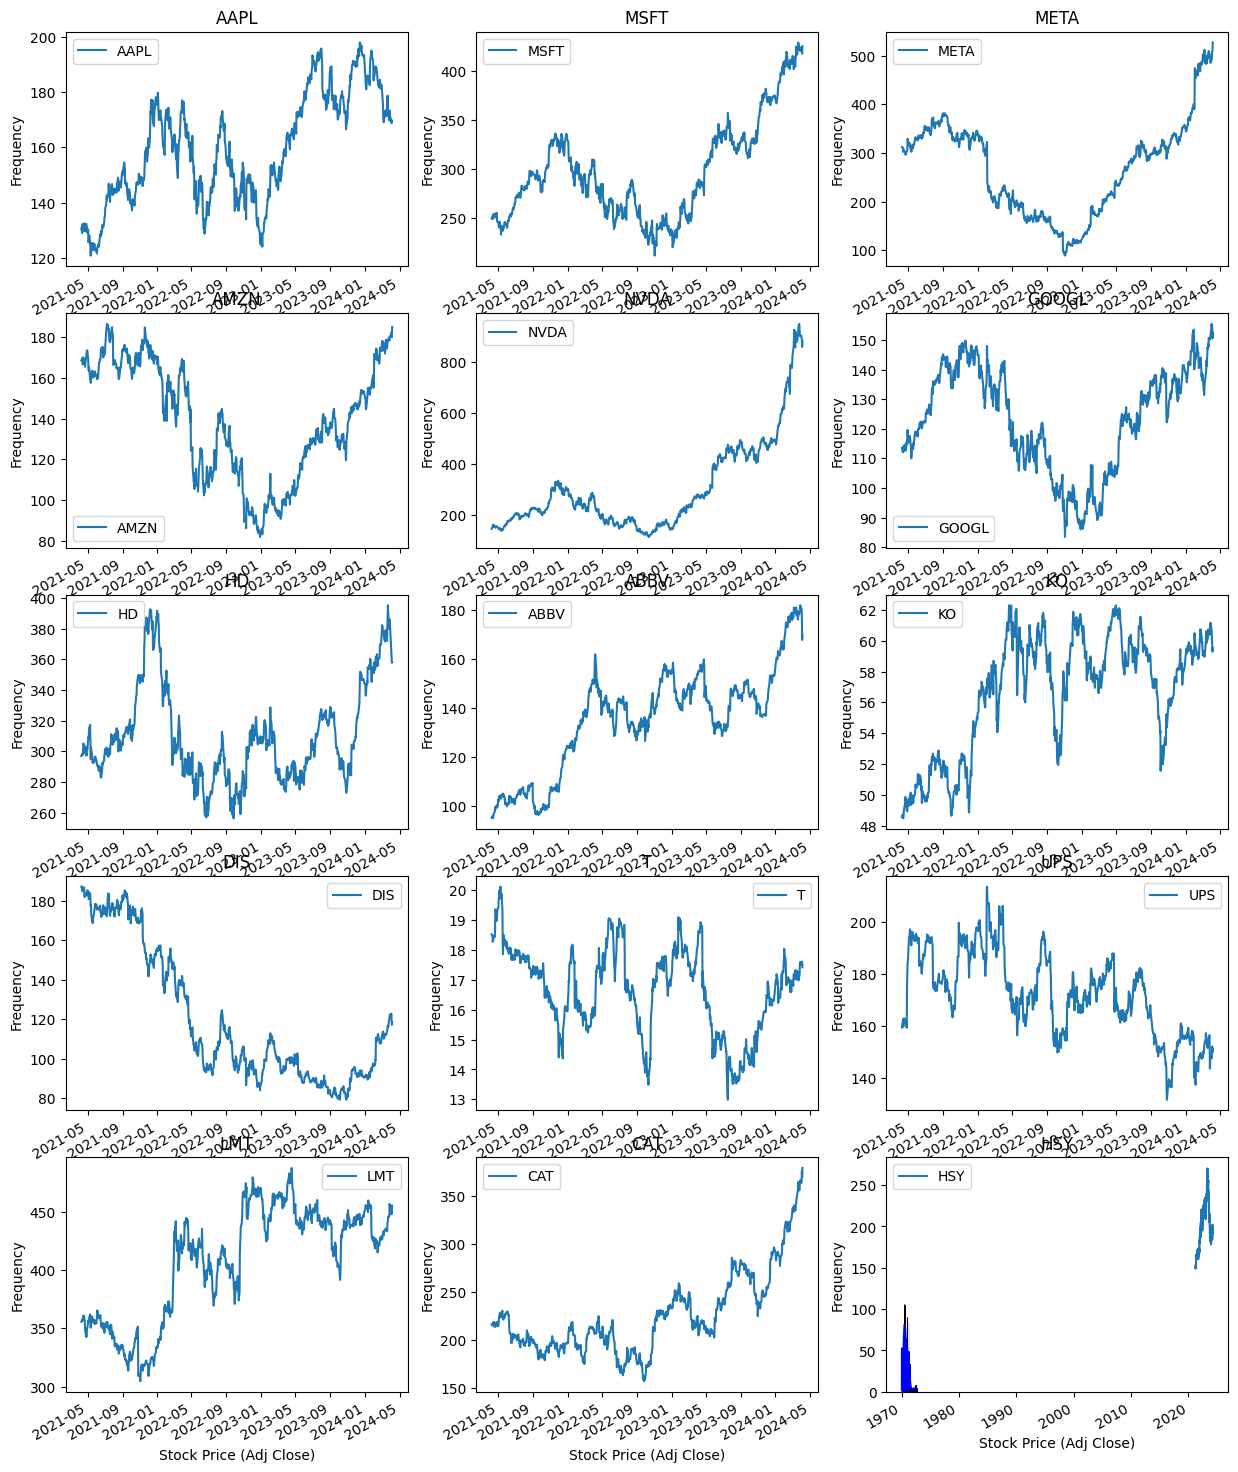

In [23]:
num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    sns.histplot(adj_close_df[ticker], kde=True, color='blue', bins=30)
    adj_close_df[ticker].plot(ax=ax, label=ticker)
    ax.set_title(ticker)
    ax.set_xlabel('Stock Price (Adj Close)')
    ax.set_ylabel('Frequency')
    ax.legend()

for i in range(len(tickers), num_rows * num_cols):
    axes[i].axis('off')


#### Calculating log returns

In [24]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns

,AAPL,MSFT,META,AMZN,NVDA,GOOGL,HD,ABBV,KO,DIS,T,UPS,LMT,CAT,HSY
Date,,,,,,,,,,,,,,,
2021-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-12,-0.013321,0.000234,-0.002949,0.002130,0.054659,-0.011539,0.004875,0.006580,0.003192,-0.007479,-0.002666,0.014894,0.004186,0.000780,0.000627
2021-04-13,0.024016,0.010031,-0.005730,0.006080,0.030467,0.004361,-0.001217,-0.000277,-0.004885,-0.005377,-0.011076,0.004693,-0.001910,-0.006865,-0.004899
2021-04-14,-0.018014,-0.011282,-0.022659,-0.019903,-0.026006,-0.005569,-0.001187,-0.009586,-0.000188,0.010565,0.003370,-0.018053,0.004022,0.013985,-0.003975
2021-04-15,0.018535,0.015182,0.016377,0.013734,0.054782,0.019147,0.008464,0.009305,0.004699,-0.008195,0.000673,0.019278,0.005030,-0.000258,0.016986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-0.008492,0.009109,0.011813,0.003266,0.000077,0.029765,-0.041436,-0.007386,-0.008206,-0.006806,-0.005698,-0.006819,-0.004583,-0.007368,0.019198
2024-04-02,-0.007023,-0.007399,0.012177,-0.001548,-0.010133,-0.005999,-0.013762,-0.000387,-0.008773,0.010559,0.001142,0.010311,0.000993,0.002992,0.011434
2024-04-03,0.004786,-0.002352,0.018664,0.009474,-0.005470,0.002326,-0.008577,-0.018770,-0.005334,-0.031764,0.005124,0.020703,-0.011852,0.029599,-0.028731


#### Counting NaN values in log returns

In [25]:
log_returns.isna().sum()

AAPL     1
MSFT     1
META     1
AMZN     1
NVDA     1
GOOGL    1
HD       1
ABBV     1
KO       1
DIS      1
T        1
UPS      1
LMT      1
CAT      1
HSY      1
dtype: int64

#### Calculating mean log returns

In [26]:
log_returns.mean()

AAPL     0.000346
MSFT     0.000711
META     0.000697
AMZN     0.000124
NVDA     0.002410
GOOGL    0.000392
HD       0.000249
ABBV     0.000772
KO       0.000270
DIS     -0.000610
T       -0.000082
UPS     -0.000070
LMT      0.000328
CAT      0.000745
HSY      0.000338
dtype: float64

#### Dropping NaN values from log returns

In [27]:
log_returns.dropna(inplace=True)

#### Calculating covariance matrix of log returns

In [28]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,AAPL,MSFT,META,AMZN,NVDA,GOOGL,HD,ABBV,KO,DIS,T,UPS,LMT,CAT,HSY
AAPL,0.071747,0.052227,0.067029,0.059594,0.084462,0.056285,0.032988,0.007920,0.016217,0.037787,0.014099,0.031184,0.010531,0.023606,0.011831
MSFT,0.052227,0.074978,0.076259,0.068699,0.096681,0.061770,0.032673,0.007943,0.015009,0.036743,0.006790,0.030044,0.006467,0.019522,0.009875
META,0.067029,0.076259,0.239623,0.107775,0.130650,0.092690,0.045562,0.002291,0.010983,0.057322,0.015716,0.043154,0.003516,0.024871,0.003927
AMZN,0.059594,0.068699,0.107775,0.140026,0.116516,0.077348,0.042426,0.007012,0.013783,0.054699,0.015556,0.040262,0.003742,0.026701,0.005808
NVDA,0.084462,0.096681,0.130650,0.116516,0.276143,0.097431,0.053197,0.007894,0.013726,0.066884,0.006210,0.054059,0.000422,0.046863,0.002325
GOOGL,0.056285,0.061770,0.092690,0.077348,0.097431,0.098717,0.032523,0.008518,0.013775,0.041502,0.011859,0.031223,0.004477,0.023362,0.007907
HD,0.032988,0.032673,0.045562,0.042426,0.053197,0.032523,0.060842,0.010181,0.015525,0.031136,0.013489,0.032192,0.009076,0.026109,0.011219
ABBV,0.007920,0.007943,0.002291,0.007012,0.007894,0.008518,0.010181,0.041120,0.012164,0.007284,0.009351,0.011296,0.007603,0.011768,0.008903
KO,0.016217,0.015009,0.010983,0.013783,0.013726,0.013775,0.015525,0.012164,0.024652,0.012385,0.013575,0.014451,0.010944,0.011129,0.017284
DIS,0.037787,0.036743,0.057322,0.054699,0.066884,0.041502,0.031136,0.007284,0.012385,0.090619,0.021188,0.032831,0.008752,0.032443,0.007134


#### Heatmap of correlation between log returns of all assets

<Axes: >

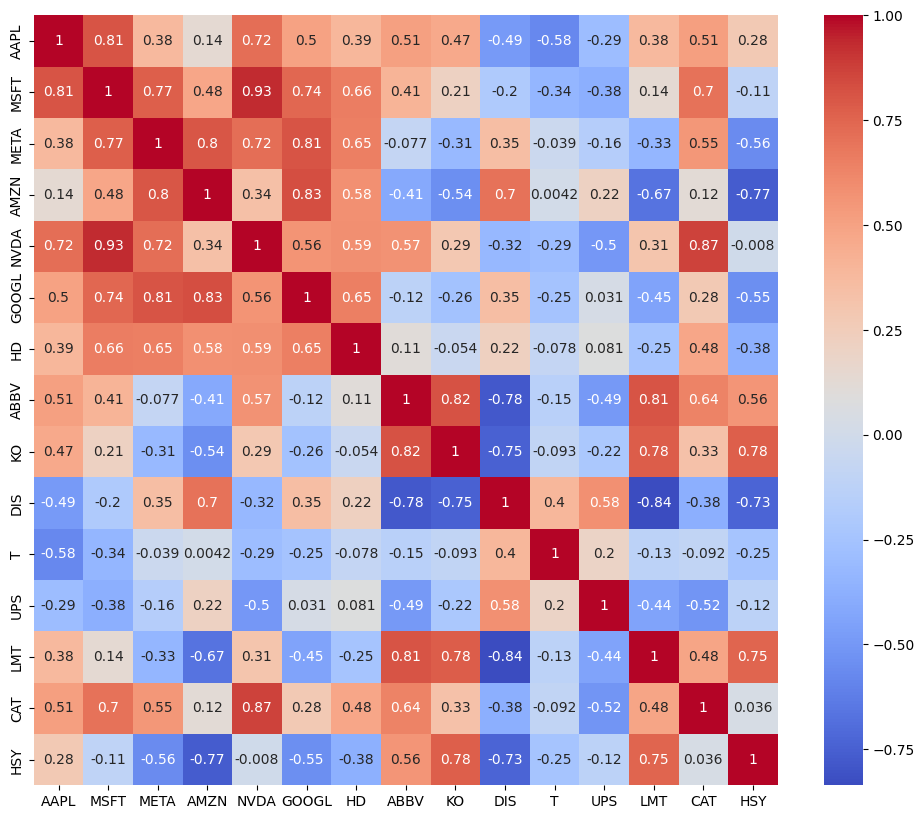

In [29]:
import matplotlib.pyplot as plt

corr_matrix = adj_close_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Defining a function to calculate standard deviation

In [30]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### Defining a function to calculate expected annualized returns

In [31]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights*252)

#### Defining a function to calculate the sharpe ratio

In [32]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

#### Retrieving risk-free rate from FRED API

In [33]:
from fredapi import Fred

fred = Fred(api_key='37d707ea29d05517c0f3f400b23644bb')
treasury_rate_10y = fred.get_series_latest_release('GS10')/100
risk_free_rate = treasury_rate_10y[-1]
risk_free_rate

/tmp/ipykernel_15788/2153171841.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = treasury_rate_10y[-1]


0.0421

#### Defining a function to calculate negative Sharpe ratio

In [34]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Defining constraints and bounds for optimization

In [35]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

#### Setting initial weights for optimization

In [36]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

#### Optimizing portfolio weights

In [37]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x


#### Printing optimal weights for each ticker

In [38]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
AAPL: 0.0000
MSFT: 0.0000
META: 0.0000
AMZN: 0.0000
NVDA: 0.3311
GOOGL: 0.0000
HD: 0.0000
ABBV: 0.5000
KO: 0.0000
DIS: 0.0000
T: 0.0000
UPS: 0.0000
LMT: 0.0618
CAT: 0.0418
HSY: 0.0653


#### Calculating expected annual return, volatility, and Sharpe ratio of the optimal portfolio

In [40]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 0.3169
Expected Volatility: 0.2163
Sharpe Ratio: 1.2701


#### Plotting Volatility vs Returns with Sharpe Ratio

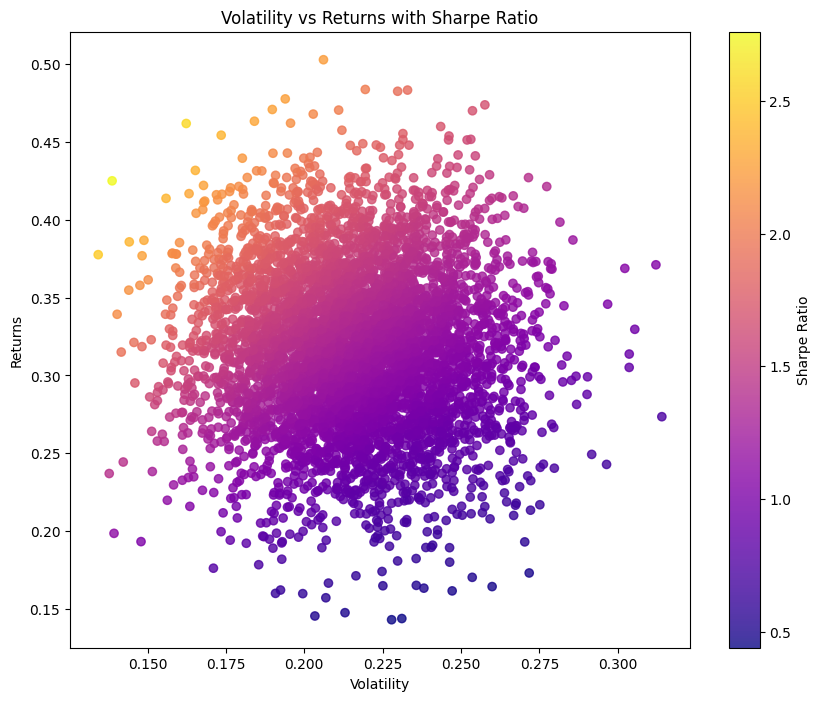

In [41]:
num_samples = 5000

volatility_samples = np.random.normal(optimal_portfolio_volatility, 0.025, num_samples)
returns_samples = np.random.normal(optimal_portfolio_return, 0.05, num_samples)
sharpe_ratio_samples = (returns_samples - risk_free_rate) / volatility_samples

plt.figure(figsize=(10,8))
plt.scatter(volatility_samples, returns_samples, c=sharpe_ratio_samples, cmap='plasma', alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Volatility vs Returns with Sharpe Ratio')
plt.show()

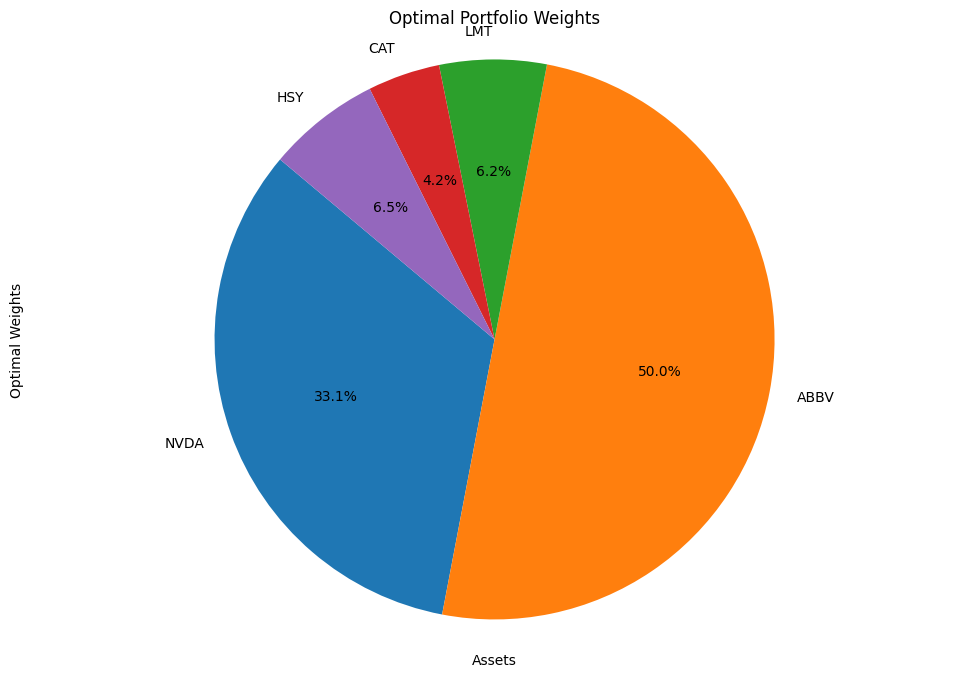

In [42]:
filtered_weights = [w for w in optimal_weights if w > 0.01]
filtered_tickers = [tickers[i] for i, w in enumerate(optimal_weights) if w > 0.01]

plt.figure(figsize=(12, 8))
plt.pie(filtered_weights, labels = filtered_tickers, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

#### Medium risk goal - Choosing the best method to maximize the weights for each asset

In [43]:
methods = ['SLSQP', 'CG', 'Nelder-Mead', 'L-BFGS-B', 'trust-constr', 'Powell']
results = {}

for method in methods:
    result = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method=method, constraints=constraints, bounds=bounds)
    optimal_weights_loop = result.x
    portfolio_return = expected_return(optimal_weights_loop, log_returns)
    portfolio_volatility = standard_deviation(optimal_weights_loop, cov_matrix)
    optimal_sharpe = sharpe_ratio(optimal_weights_loop, log_returns, cov_matrix, risk_free_rate)

    results[method] = optimal_sharpe

for method, sharpe in results.items():
    print(f"Sharpe ratio using {method}: {sharpe}")

best_method = max(results, key=results.get)
print(f"\nBest method for portfolio optimization: {best_method}")

/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method CG cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the appr

Sharpe ratio using SLSQP: 1.2700650115150067
Sharpe ratio using CG: 2.14384019298653
Sharpe ratio using Nelder-Mead: 1.1469940057834098
Sharpe ratio using L-BFGS-B: 1.3138490446990432
Sharpe ratio using trust-constr: 1.015146649593206
Sharpe ratio using Powell: 1.3136082474540227

Best method for portfolio optimization: CG


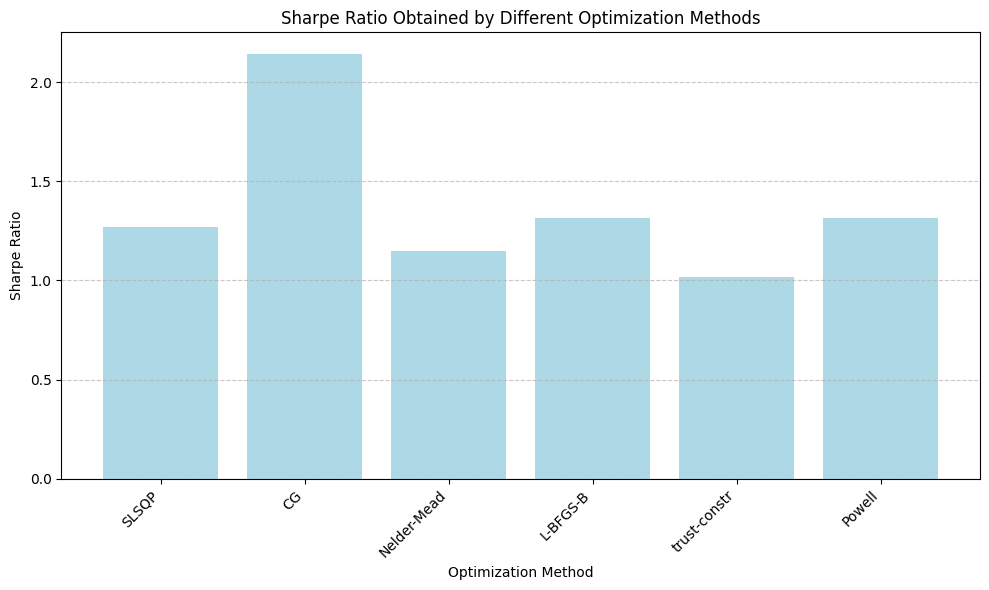

In [44]:
methods = list(results.keys())
ratios = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(methods, ratios, color='lightblue')
plt.xlabel('Optimization Method')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Obtained by Different Optimization Methods')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Re-Computing Sharpe ratios using the most optimal (CG) method

In [45]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='CG', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x

/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method CG cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/home/nail/miniconda3/envs/portfolio/lib/python3.12/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [46]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, y):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:


NameError: name 'y' is not defined

In [ ]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.2f}%")
print(f"Expected Volatility: {optimal_portfolio_volatility:.2f}%")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 77.36%
Expected Volatility: 34.71%
Sharpe Ratio: 2.2272


#### Generating samples for plotting Volatility vs Returns with Sharpe Ratio

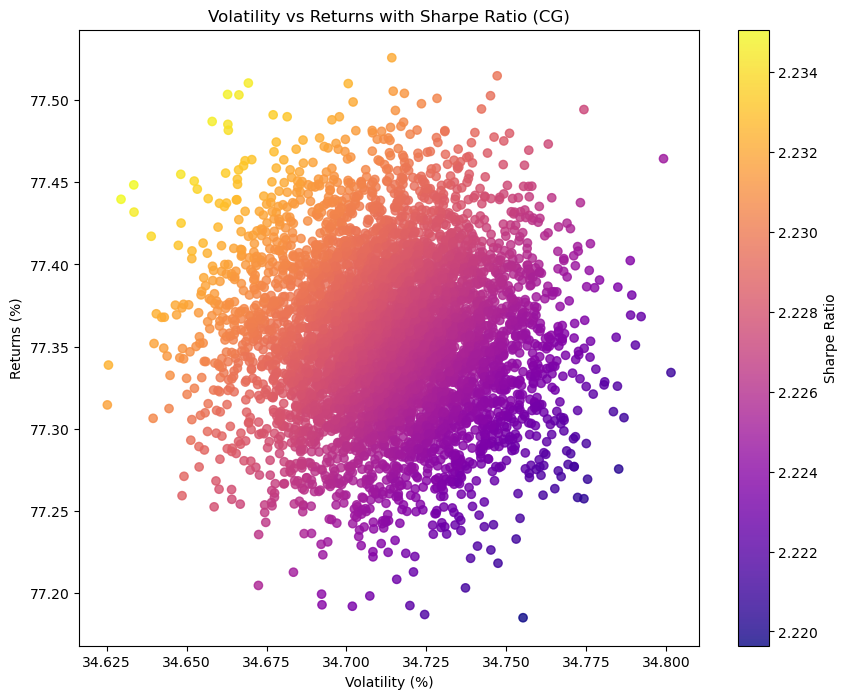

In [ ]:
num_samples = 5000

volatility_samples = np.random.normal(optimal_portfolio_volatility, 0.025, num_samples)
returns_samples = np.random.normal(optimal_portfolio_return, 0.05, num_samples)
sharpe_ratio_samples = (returns_samples - risk_free_rate) / volatility_samples

plt.figure(figsize=(10,8))
plt.scatter(volatility_samples, returns_samples, c=sharpe_ratio_samples, cmap='plasma', alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility (%)')
plt.ylabel('Returns (%)')
plt.title('Volatility vs Returns with Sharpe Ratio (CG)')
plt.show()

#### Plotting Volatility vs Returns with Sharpe Ratio

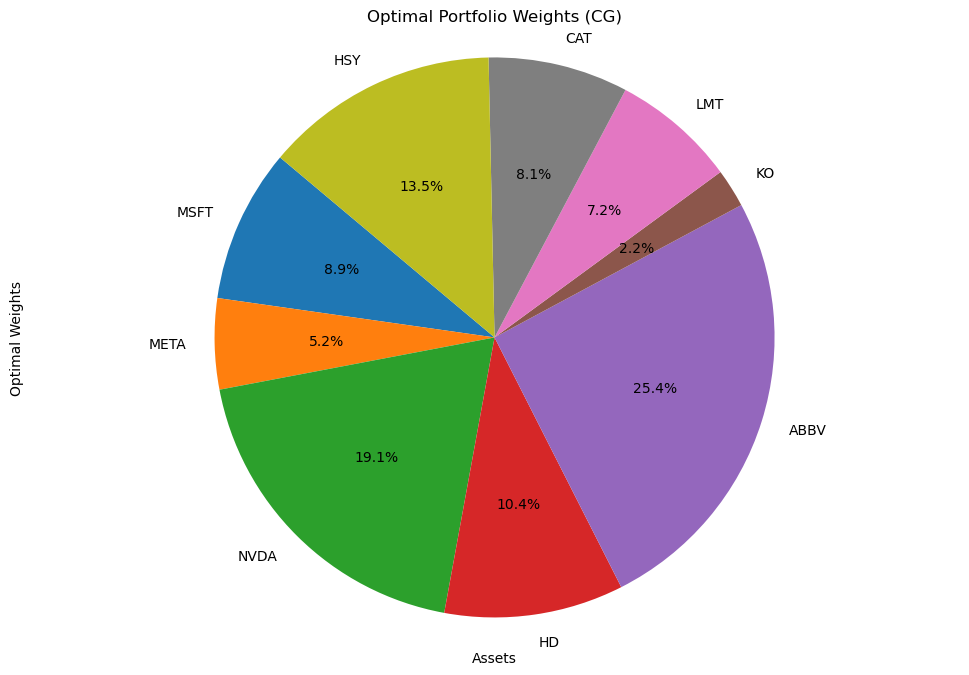

In [ ]:
filtered_weights = [w for w in optimal_weights if w > 0.01]
filtered_tickers = [tickers[i] for i, w in enumerate(optimal_weights) if w > 0.01]

plt.figure(figsize=(12, 8))
plt.pie(filtered_weights, labels = filtered_tickers, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights (CG)')

plt.show()

## Black-Litterman Implementation

In [47]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from fredapi import Fred
from pypfopt import black_litterman


avg_returns = {}
for ticker in tickers:
    prices = adj_close_df[ticker]
    returns = prices.pct_change().dropna()  # Calculate daily returns, dropping NA values
    avg_returns[ticker] = returns.mean() * 252


print("Average Returns for Each Stock:")
print(avg_returns)


# # Download market index data (e.g., S&P 500)
# market_index = '^GSPC'  # S&P 500 index ticker
# market_data = yf.download(market_index, start=start_date, end=end_date)['Adj Close']

# # Calculate excess returns for stocks and market index
# excess_returns = adj_close_df.pct_change() - risk_free_rate
# market_excess_returns = market_data.pct_change() - risk_free_rate

# # Perform linear regression for each stock
# regression_results = {}
# for ticker in tickers:
#     excess_returns_ticker = excess_returns[ticker].dropna()
#     excess_returns_market = market_excess_returns.dropna()

#     slope, intercept, r_value, p_value, std_err = stats.linregress(excess_returns_market, excess_returns_ticker)
#     regression_results[ticker] = {'slope': slope, 'intercept': intercept}
# print(regression_results)
# # Calculate expected returns using CAPM
# expected_returns = {}
# for ticker, result in regression_results.items():
#     beta = result['slope']
#     expected_returns[ticker] = risk_free_rate + beta * (market_excess_returns.mean())
# print(expected_returns)
# Calculate deviations from market-implied returns
# market_prior_returns = black_litterman.market_implied_prior_returns(tickers, market_data, risk_free_rate)
# views = {}
# for ticker, expected_return in expected_returns.items():
#     view = expected_return - market_prior_returns[ticker]
#     views[ticker] = view

# print("Regression-Derived Expected Returns:")
# print(expected_returns)
# print("\nViews (Deviation from Market Prior Returns):")
# print(views)


Average Returns for Each Stock:
{'AAPL': 0.12307410860348282, 'MSFT': 0.21673416324412775, 'META': 0.29403844139520724, 'AMZN': 0.10110105613086116, 'NVDA': 0.747159742221148, 'GOOGL': 0.14813425138917785, 'HD': 0.09297593715262005, 'ABBV': 0.21505845167793117, 'KO': 0.08045496262285258, 'DIS': -0.10855585193727432, 'T': 0.010846257604250453, 'UPS': 0.019992512118730318, 'LMT': 0.10566432029862063, 'CAT': 0.22932998356210885, 'HSY': 0.102828900485977}


In [48]:
market_prices = yf.download("SPY", start='2018-01-01', end='2023-02-28')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    242.319336
2018-01-03    243.852081
2018-01-04    244.879913
2018-01-05    246.511780
2018-01-08    246.962540
Name: Adj Close, dtype: float64

In [49]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2618637418496,
 'MSFT': 3161800835072,
 'META': 1344406028288,
 'AMZN': 1922396192768,
 'NVDA': 2200200019968,
 'GOOGL': 1901995229184,
 'HD': 354660253696,
 'ABBV': 301010485248,
 'KO': 256558907392,
 'DIS': 217144426496,
 'T': 124961144832,
 'UPS': 129130823680,
 'LMT': 109516619776,
 'CAT': 189413687296,
 'HSY': 39564034048}

In [50]:
S = risk_models.CovarianceShrinkage(adj_close_df).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

ImportError: Please install scikit-learn via pip or poetry

<Axes: >

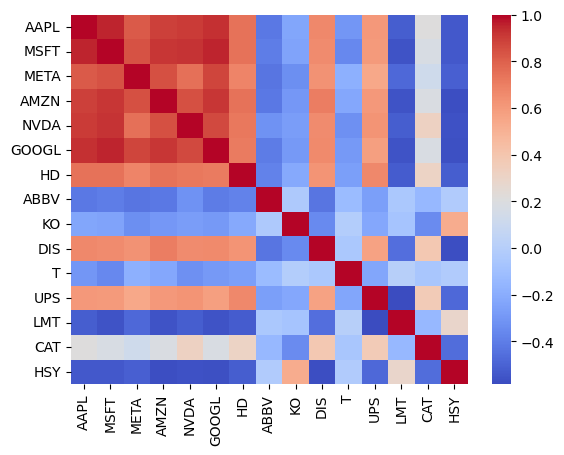

In [ ]:
sns.heatmap(S.corr(), cmap='coolwarm')

In [ ]:
# market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
# market_prior
# views = {}
# for ticker, expected_return in expected_returns.items():
#     view = expected_return - market_prior[ticker]
#     views[ticker] = view

# print("Regression-Derived Expected Returns:")
# print(expected_returns)
# print("\nViews (Deviation from Market Prior Returns):")
# print(views)

In [ ]:
# market_prior.plot.barh(figsize=(10,5));

[*********************100%%**********************]  1 of 1 completed


Investor Views (Deviation from Market Prior Returns):
{'AAPL': 0.03222443640939926, 'MSFT': 0.08538637150513223, 'META': 0.11487910137477023, 'AMZN': -0.07502074579304638, 'NVDA': 0.46853967711452127, 'GOOGL': 0.0015544811728246122, 'HD': 0.08356332971772942, 'ABBV': 0.19323427702201523, 'KO': 0.060533150186612567, 'DIS': -0.2550663601486537, 'T': -0.021267747438956472, 'UPS': -0.0436186296991515, 'LMT': 0.09622128745613052, 'CAT': 0.11683128796312155, 'HSY': 0.09146986521305314}


/var/folders/t1/r4wwd84d6xb75g5c6kcczbsm0000gn/T/ipykernel_15350/4178322865.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = Fred(api_key='37d707ea29d05517c0f3f400b23644bb').get_series_latest_release('DGS10')[-1] / 100  # 10-year treasury yield


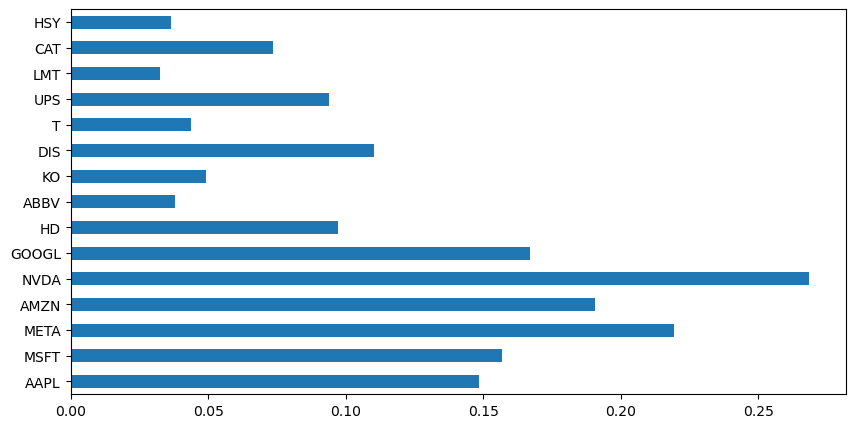

In [ ]:
#You don't have to provide views on all the assets
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'META':0.05,
    'AMZN':0.30,
    'NVDA':0.02,
    'GOOGL':0.01,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'HSY':-0.26
}
tickers = list(avg_returns.keys())  # Get list of tickers
market_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']  # Download S&P 500 data as market proxy
risk_free_rate = Fred(api_key='37d707ea29d05517c0f3f400b23644bb').get_series_latest_release('DGS10')[-1] / 100  # 10-year treasury yield
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Calculate deviations from market-implied returns
views = {}
for ticker, avg_return in avg_returns.items():
    view = avg_return - market_prior[ticker]
    views[ticker] = view

print("Investor Views (Deviation from Market Prior Returns):")
print(views)
market_prior.plot.barh(figsize=(10,5));
viewdict= views
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25)
]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005]


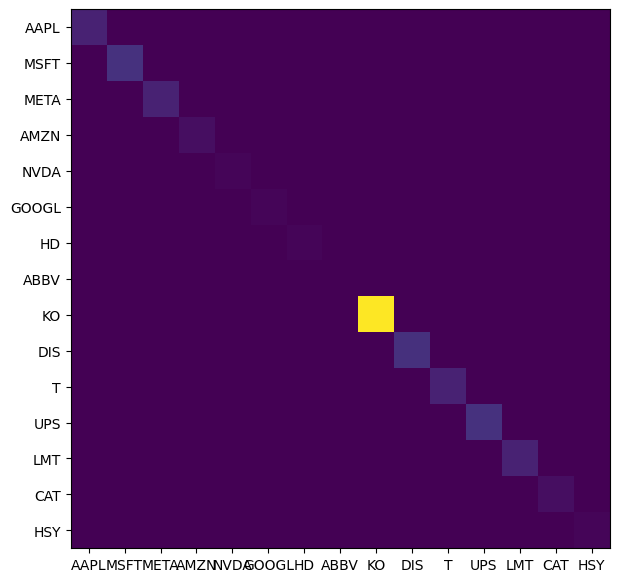

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
# bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.071950
MSFT     0.087781
META     0.083022
AMZN     0.029430
NVDA     0.224896
GOOGL    0.059704
HD       0.061624
ABBV     0.110707
KO       0.055766
DIS     -0.070521
T        0.000309
UPS      0.015345
LMT      0.066200
CAT      0.070265
HSY      0.062035
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.148317,0.071950,0.032224
MSFT,0.156662,0.087781,0.085386
META,0.219339,0.083022,0.114879
AMZN,0.190668,0.029430,-0.075021
NVDA,0.268336,0.224896,0.468540
GOOGL,0.166973,0.059704,0.001554
HD,0.097270,0.061624,0.083563
ABBV,0.037903,0.110707,0.193234
KO,0.049194,0.055766,0.060533
DIS,0.110421,-0.070521,-0.255066


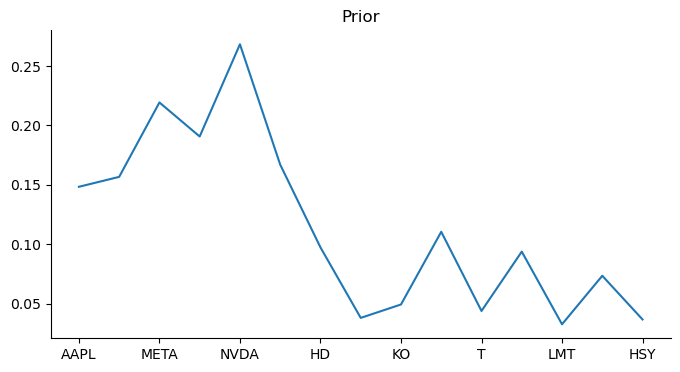

In [ ]:
# @title Prior

from matplotlib import pyplot as plt
rets_df['Prior'].plot(kind='line', figsize=(8, 4), title='Prior')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

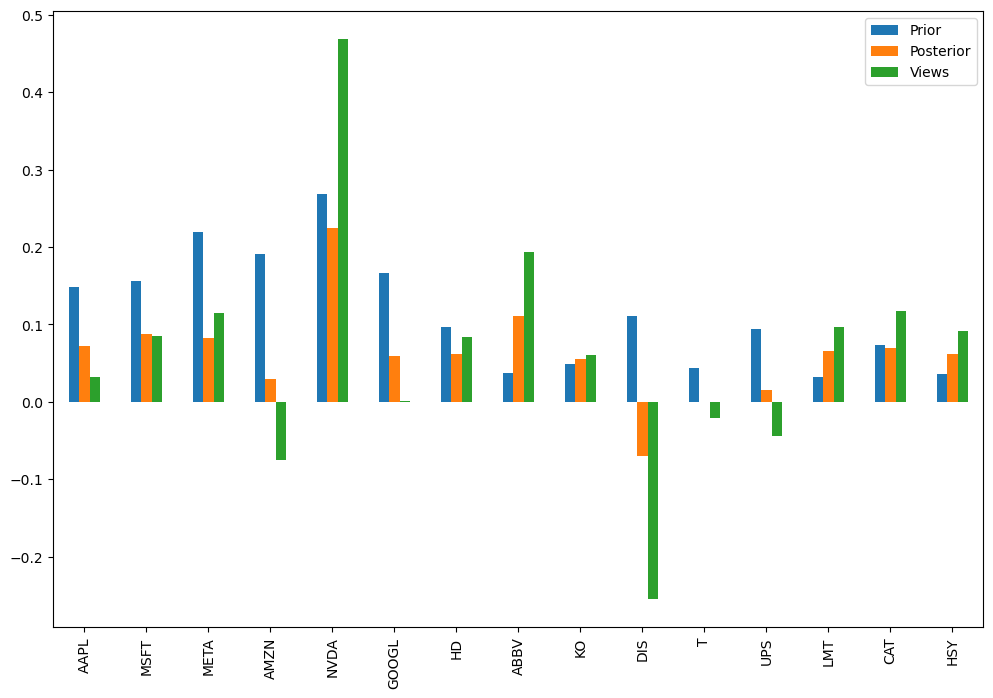

In [ ]:
rets_df.plot.bar(figsize=(12,8))

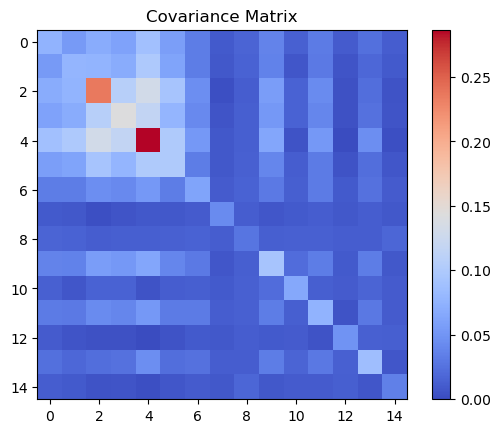

In [ ]:
S_bl = bl.bl_cov()
plt.imshow(S_bl, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Covariance Matrix')
plt.show()

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/achyut/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.05484),
             ('MSFT', 0.08286),
             ('META', 0.05448),
             ('AMZN', 0.0),
             ('NVDA', 0.28807),
             ('GOOGL', 0.02682),
             ('HD', 0.04967),
             ('ABBV', 0.16367),
             ('KO', 0.05618),
             ('DIS', 0.0),
             ('T', 0.0),
             ('UPS', 0.0),
             ('LMT', 0.08105),
             ('CAT', 0.06946),
             ('HSY', 0.0729)])

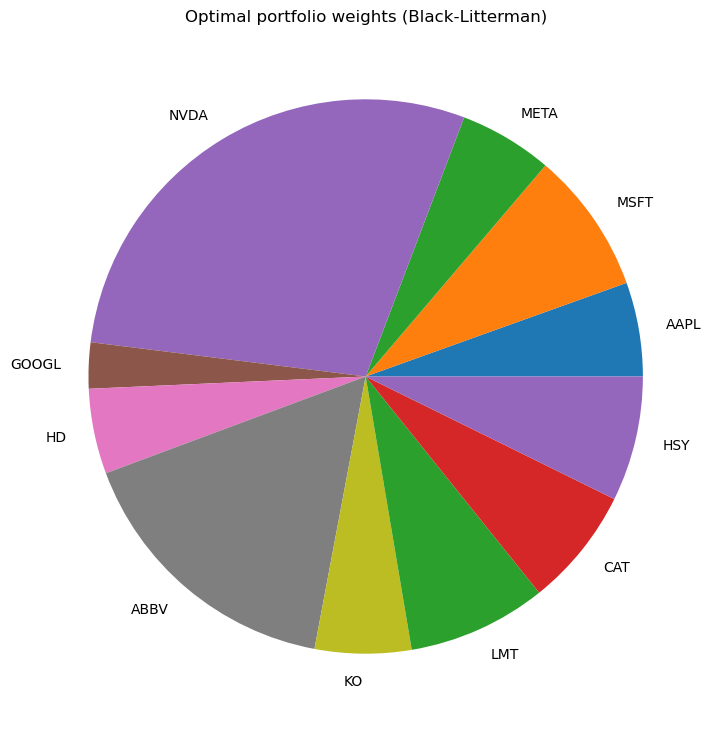

In [ ]:
plt.title('Optimal portfolio weights (Black-Litterman)')
pd.Series(weights).plot.pie(figsize=(9,9));

In [ ]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)